# 1. Introduction and Competition Overview
In this notebook, we will tackle a Kaggle competition aimed at predicting whether tweets are related to disasters. We will start by using two simple techniques: TF-IDF and CountVectorizer, combined with Ridge, Logistic Regression models and Latent Semantic Analyzes (LSA), to create baseline results. The first section focuses on exploring the dataset to gain a deeper understanding of the data. After establishing these baselines, we will move on to a more advanced approach by incorporating the BERT transformer model as a layer in a neural network using TensorFlow.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from sklearn import feature_extraction, linear_model, model_selection, preprocessing, decomposition, metrics

import seaborn as sns
#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


###plot config
%matplotlib inline
%config InlineBackend.figure_format='retina'


#data processing
import re, string

import string

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet
from nltk.corpus import stopwords

nltk.download('punkt')

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
    
# Atualizar pip
!pip install allennlp==1.0.0
!pip install transformers

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
     |████████████████████████████████| 481kB 6.3MB/s 
     |████████████████████████████████| 675kB 25.8MB/s 
     |████████████████████████████████| 753.2MB 11kB/s 
     |████████████████████████████████| 880kB 44.2MB/s 
     |████████████████████████████████| 3.8MB 27.8MB/s 
  Created wheel for overrides: filename=overrides-3.0.0-cp36-none-any.whl size=5669 sha256=0f53e34a7949857a81650644ac9860da4e10ce8754e0ed6cbbd3b23b78415277
  Stored in directory: /root/.cache/pip/wheels/6f/1b/ec/6c71a1eb823df7f850d956b2d8c50a6d49c191e1063d73b9be
  Created wheel for sacremoses: filename=sacremoses-0.0.53-cp36-none-any.whl size=895254 sha256=1948b121a1ae0a98d77aeb2909ccc2458eee4623c08229cede27253374822bcf
  Store

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# 2. Data Exploration and Preprocessing

## 2.1 A quick look at the data

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The data contains text (tweets), keyword, location and target. For now, let's focus only on the text and on the target. Now, let's look if the data is balanced

In [5]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

The data is balanced, so we are good to go. Now let's take a look on some examples of tweets that are not disasters

In [6]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is

In [7]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

## Custom **functions** for text processing

In [8]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

# Lemmatize the corpus
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

def Tokenizer(doc):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(doc) #List of strings in doc
        
    filtered_words = [token.lower() for token in tokens]
#    filtered_words = [token.lower() for token in tokens if (token.lower() not in stop_words) and (token.lower() not in string.punctuation)]
        
    words_and_tags = nltk.pos_tag(filtered_words)
    return " ".join([wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags])

#Number of words in text
def len_text(text):
    return len(text.split(" "))

## 2.2 Pre-processing

- Lowercase
- Lemmatize document
- Remove \n and \r
- Remove links and mentions
- Remove non utf8/ascii characters
- Remove hashtags

In [9]:
train_df['text_clean'] = train_df['text'].apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).apply(Tokenizer)
test_df['text_clean'] = test_df['text'].apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).apply(Tokenizer)

In [10]:
train_df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed be the reason of this earthquake may ...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resident ask to shelter in place be be not...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just get send this photo from ruby alaska a sm...


In [11]:
train_df['len_keyword'] = train_df['keyword'].astype(str).apply(len_text)
train_df['len_text'] = train_df['text_clean'].astype(str).apply(len_text)

In [12]:
train_df.head()

,id,keyword,location,text,target,text_clean,len_keyword,len_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed be the reason of this earthquake may ...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resident ask to shelter in place be be not...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just get send this photo from ruby alaska a sm...,1,16


In [13]:
text_len = train_df['len_text'].value_counts().sort_index().reset_index(name ='counts')
keyword_len = train_df['len_keyword'].value_counts().sort_index().reset_index(name ='counts')

### Feature: text

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


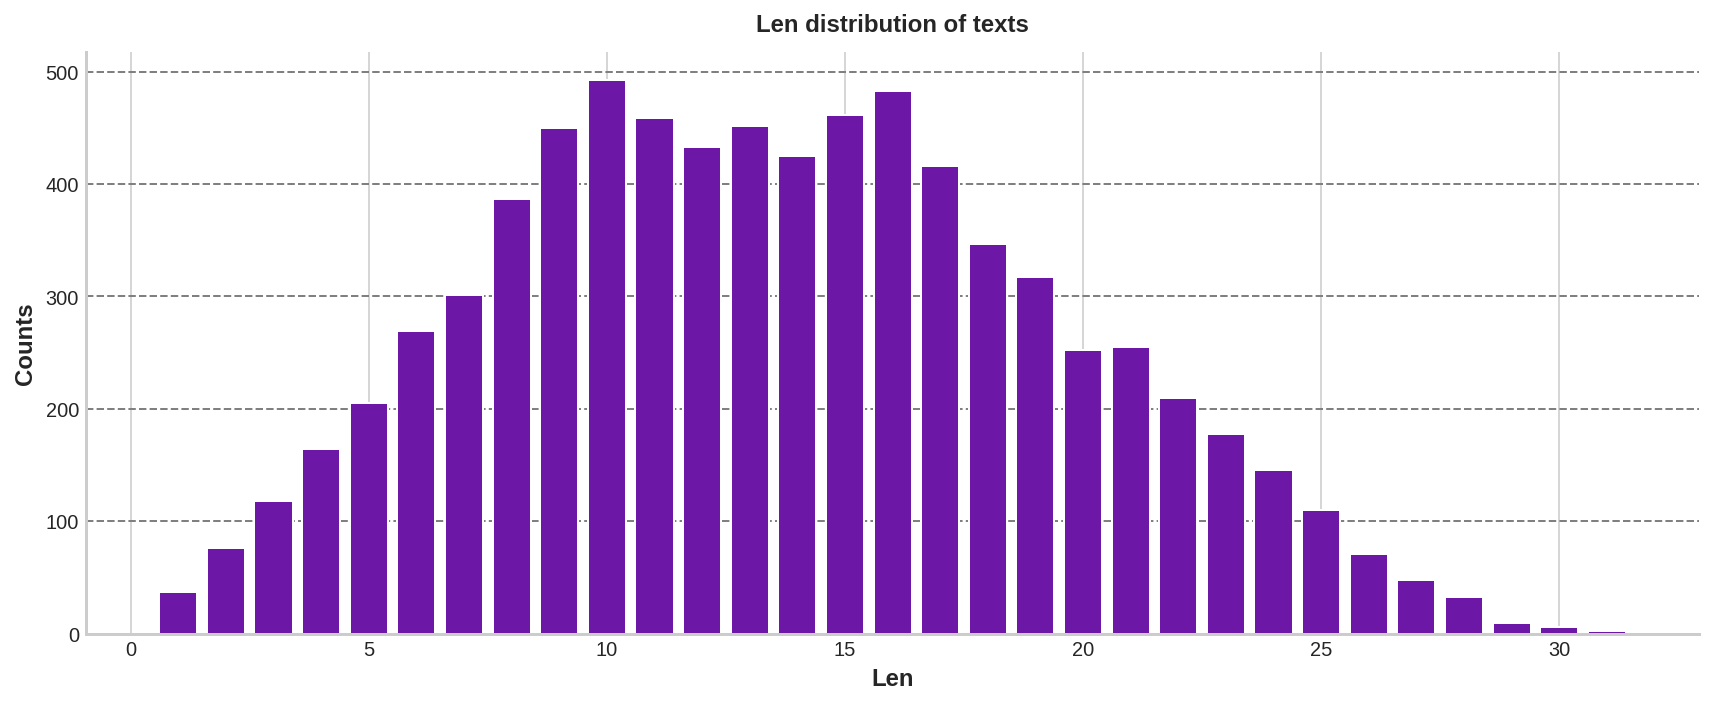

In [14]:
#Visualize text length

fig, ax = plt.subplots(figsize=(12,5))

# Data
ax.bar(text_len['index'].values, text_len['counts'].values, color="#6d17a6")

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
#ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Len')
ax.set_ylabel('Counts')
ax.set_title('Len distribution of texts')

plt.show()

Now, lets take a look on some extremes values of text length

In [15]:
train_df[train_df['len_text']>25].head(10)

,id,keyword,location,text,target,text_clean,len_keyword,len_text
11,17,NaN,NaN,Haha South Tampa is getting flooded hah- WAIT ...,1,haha south tampa be get flood hah wait a secon...,1,29
49,71,ablaze,England.,First night with retainers in. It's quite weir...,0,first night with retainer in it quite weird go...,1,27
67,96,accident,CLVLND,'I can't have kids cuz I got in a bicycle acci...,0,i cant have kid cuz i get in a bicycle acciden...,1,27
80,117,accident,NaN,mom: 'we didn't get home as fast as we wished'...,0,mom we didnt get home as fast a we wish me why...,1,26
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1,9 mile backup on i77 southaccident block the r...,1,26
128,184,aftershock,304,'Remembering that you are going to die is the ...,0,remember that you be go to die be the best way...,1,26
290,424,apocalypse,"San Antonio-ish, TX",Dad bought a DVD that looks like a science doc...,1,dad buy a dvd that look like a science doc on ...,1,26
465,672,attack,"Scotland, United Kingdom",'Left hand side of a diamond is a graveyard sh...,0,left hand side of a diamond be a graveyard shi...,1,27
643,932,blaze,NaN,Life is amazin same time its crazy niggas dey ...,0,life be amazin same time it crazy nigga dey wa...,1,27
734,1062,bleeding,NaN,Deadpool is already one of my favourite marvel...,0,deadpool be already one of my favourite marvel...,1,28


In [16]:
train_df[train_df['len_text']<5].head(10)

,id,keyword,location,text,target,text_clean,len_keyword,len_text
15,23,NaN,NaN,What's up man?,0,whats up man,1,3
16,24,NaN,NaN,I love fruits,0,i love fruit,1,3
17,25,NaN,NaN,Summer is lovely,0,summer be lovely,1,3
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,what a goooooooaaaaaal,1,3
20,31,NaN,NaN,this is ridiculous....,0,this be ridiculous,1,3
21,32,NaN,NaN,London is cool ;),0,london be cool,1,3
22,33,NaN,NaN,Love skiing,0,love skiing,1,2
23,34,NaN,NaN,What a wonderful day!,0,what a wonderful day,1,4
24,36,NaN,NaN,LOOOOOOL,0,looooool,1,1
27,39,NaN,NaN,Love my girlfriend,0,love my girlfriend,1,3


In [17]:
#Lets see how balanced is this sample (len_text < 5)
train_df[train_df['len_text']<5]['target'].value_counts()

0    314
1     81
Name: target, dtype: int64

### Feature: Keyword

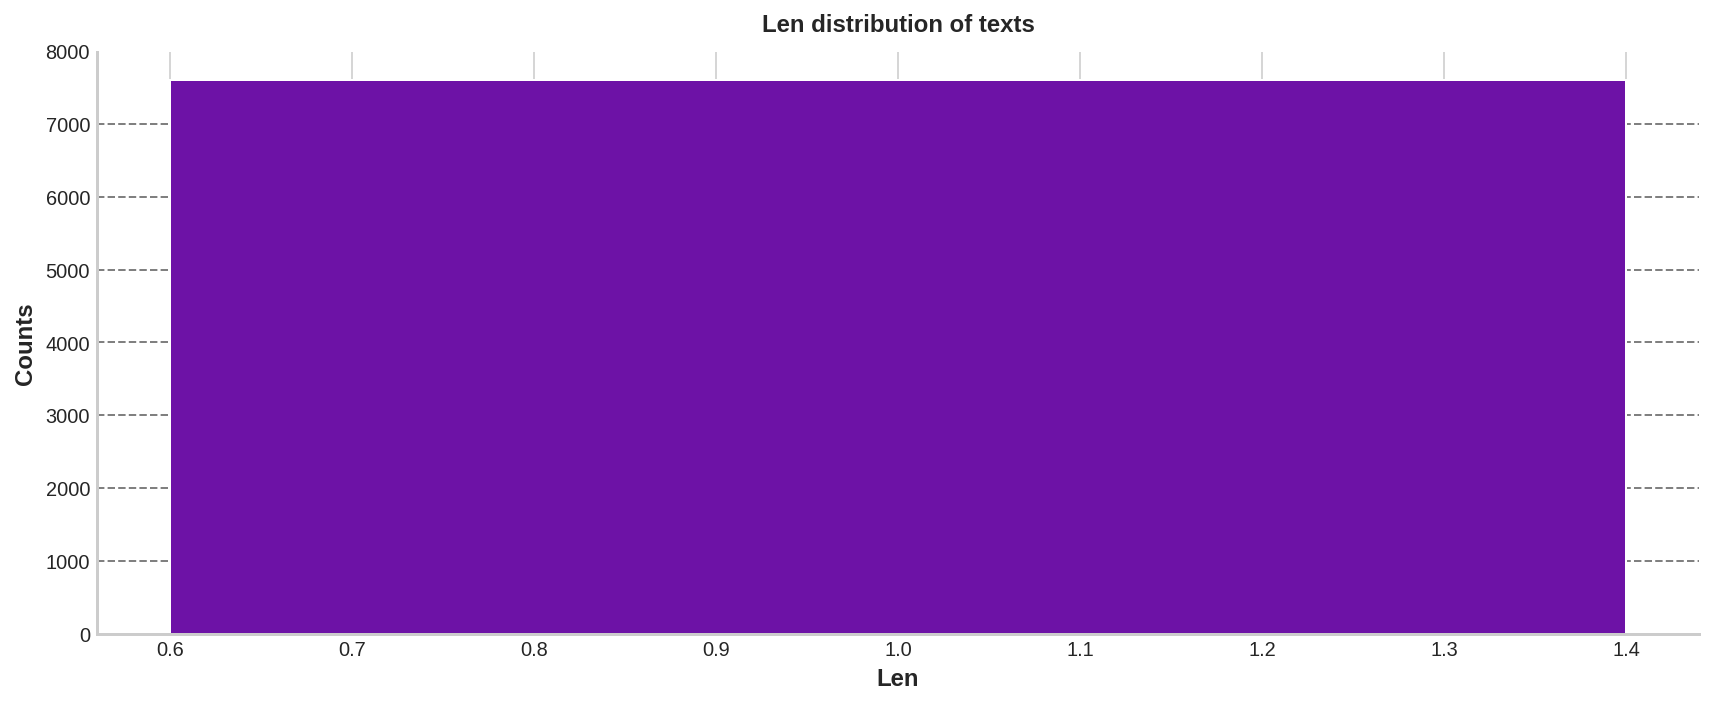

In [18]:
#Visualize text length

fig, ax = plt.subplots(figsize=(12,5))

# Data
ax.bar(keyword_len['index'].values, keyword_len['counts'].values, color="#6d12a6")

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
#ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Len')
ax.set_ylabel('Counts')
ax.set_title('Len distribution of texts')

plt.show()

In [19]:
print(keyword_len)

   index  counts
0      1    7613


In [20]:
#Check how many different keywords does this dataset has.
unique_kw = train_df['keyword'].unique()

len(unique_kw)

222

In [21]:
def get_target_proportion(group):
    total_count = group.shape[0]
    disaster_count = group[group['target'] == 1].shape[0]
    proportion = disaster_count / total_count if total_count > 0 else 0
    
    return pd.Series({'proportion': proportion, 'count': total_count})



#Let's see if these keywords correlates with disasters
group_kw = train_df[['keyword','target']].groupby('keyword').apply(get_target_proportion)

In [22]:
group_kw.sort_values(ascending = False, by = ['proportion','count'])

,proportion,count
keyword,,
derailment,1.000000,39.0
wreckage,1.000000,39.0
debris,1.000000,37.0
outbreak,0.975000,40.0
oil%20spill,0.973684,38.0
...,...,...
body%20bag,0.030303,33.0
blazing,0.029412,34.0
ruin,0.027027,37.0


## 2.3 Insights:

- The average number of words/tweet is about 12 and it seems to follow a normal distribution. 
- There is no need to filter these tweets by their lenght size. 
- It's possible to noticed that each tweet has only one keyword at maximum.
- The keywords seems to add context, so it may be usefull to add to the features.

## 2.4 Feature selection

We will create a new feature concatenating the keyword and text columns to see if it enhances performance.

In [23]:
#clean keywords
train_df['keyword_clean'] = train_df['keyword'].astype(str).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)
test_df['keyword_clean'] = test_df['keyword'].astype(str).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)

In [24]:
train_df['text_kw_clean'] = np.where(~train_df['keyword_clean'].str.contains("nan"),train_df['text_clean']+" "+train_df['keyword_clean'], train_df['text_clean'])
test_df['text_kw_clean'] = np.where(~test_df['keyword_clean'].str.contains("nan"),test_df['text_clean']+" "+test_df['keyword_clean'], test_df['text_clean'])

In [25]:
train_df['text_kw_clean'][12]

'rain flood florida tampabay tampa 18 or 19 day ive lose count'

# 3. Baseline model

In this section, we will establish baseline models using fundamental text vectorization techniques, namely CountVectorizer and TF-IDF. We will apply two classical machine learning algorithms, Logistic Regression and Ridge Classifier, to these vectorized representations. These baseline models will serve as a benchmark for evaluating the performance of more advanced techniques later in the analysis.

## 3.1 Building vectors

We will try different approaches to build the input vector to see which one does better:

1. Count vectorizer
2. TfIdf

### 3.1.1 Count vectorizer

In [26]:
#Count vectorizer method
count_vectorizer = feature_extraction.text.CountVectorizer(lowercase=True)

train_vectors = count_vectorizer.fit_transform(train_df["text_clean"])
test_vectors = count_vectorizer.transform(test_df["text_clean"])

In [27]:
V = len(count_vectorizer.vocabulary_)
print(f"Vocabulary size: {V}")

Vocabulary size: 13450


### Model with count vectorizer
Let's try different models to fit our data and see how they perform. For this we'll use cross-validation - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [28]:
#RidgeClassifier
clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
print(f"Average score: {scores.mean()}\nList of scores: {scores}")

clf.fit(train_vectors, train_df["target"])
predict = clf.predict(train_vectors)
print(f'\nF1 score (train data) using all the data {metrics.f1_score(train_df["target"] ,predict)}')

Average score: 0.6031408180631429
List of scores: [0.60989291 0.55878013 0.64074941]

F1 score (train data) using all the data 0.9725197950628786


In [29]:
#LinearRegression with L2
clf = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter=1000)

scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
print(f"Average score: {scores.mean()}\nList of scores: {scores}")

clf.fit(train_vectors, train_df["target"])
predict = clf.predict(train_vectors)
print(f'\nF1 score (train data) using all the data {metrics.f1_score(train_df["target"] ,predict)}')

Average score: 0.6350533250883781
List of scores: [0.63665595 0.60774578 0.66075825]

F1 score (train data) using all the data 0.934875614007289


Between this two models, the linear regression with L2 had a better score (near 8% of improvement). Now, let's try to use a LSA layer before fitting the model, to see if we can see any improvement. Also, we notice that the f1 scores using cross validation was lower, which may indicate that the model is overfitting.

## 3.1.2 Tf - Idf

In [30]:
#Count vectorizer method
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(lowercase=True)

train_vectors_idf = tfidf_vectorizer.fit_transform(train_df["text_clean"])
test_vectors_idf = tfidf_vectorizer.transform(test_df["text_clean"])

### Model with Tf-idf

In [31]:
#RidgeClassifier
clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(clf, train_vectors_idf, train_df["target"], cv=3, scoring="f1")
print(f"Average score: {scores.mean()}\nList of scores: {scores}")

Average score: 0.6398059942506573
List of scores: [0.64643237 0.60268318 0.67030243]


In [32]:
#LinearRegression with L2
clf = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter=1000)

scores = model_selection.cross_val_score(clf, train_vectors_idf, train_df["target"], cv=3, scoring="f1")
print(f"Average score: {scores.mean()}\nList of scores: {scores}")

Average score: 0.6329428707167883
List of scores: [0.625      0.60716195 0.66666667]


We improved our score using tf-idf with RidgeClassifier. Let's see if we can improve even more using Tf-idf with LSA.

## 3.1.3 Tf-idf with LSA

In [33]:
SVD_model = decomposition.TruncatedSVD(n_components=2)

In [34]:
train_z = SVD_model.fit_transform(train_vectors_idf)
test_z = SVD_model.fit(test_vectors_idf)

### Models with Tf-Idf with LSA

In [35]:
#RidgeClassifier
clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(clf, train_z, train_df["target"], cv=3, scoring="f1")
print(f"Average score: {scores.mean()}\nList of scores: {scores}")

Average score: 0.5399442473066468
List of scores: [0.55377827 0.46678024 0.59927424]


In [36]:
#LinearRegression with L2
clf = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter=1000)

scores = model_selection.cross_val_score(clf, train_z, train_df["target"], cv=3, scoring="f1")
print(f"Average score: {scores.mean()}\nList of scores: {scores}")

Average score: 0.5382850487893235
List of scores: [0.55438984 0.46885617 0.59160913]


In [37]:
logistic_regression_f1 = []
ridge_classifier_f1 = []
number_list = [200,400,700,900,1100, 1300]
#number_list = [700,900,1100]

for number_components in number_list:
    SVD_model_aux = decomposition.TruncatedSVD(n_components=number_components)
    train_z_aux = SVD_model_aux.fit_transform(train_vectors_idf)
    
    clf = linear_model.RidgeClassifier()
    scores = model_selection.cross_val_score(clf, train_z_aux, train_df["target"], cv=3, scoring="f1")
    ridge_classifier_f1.append(scores.mean())
    
    clf = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter=1000)
    scores = model_selection.cross_val_score(clf, train_z_aux, train_df["target"], cv=3, scoring="f1")
    logistic_regression_f1.append(scores.mean())

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


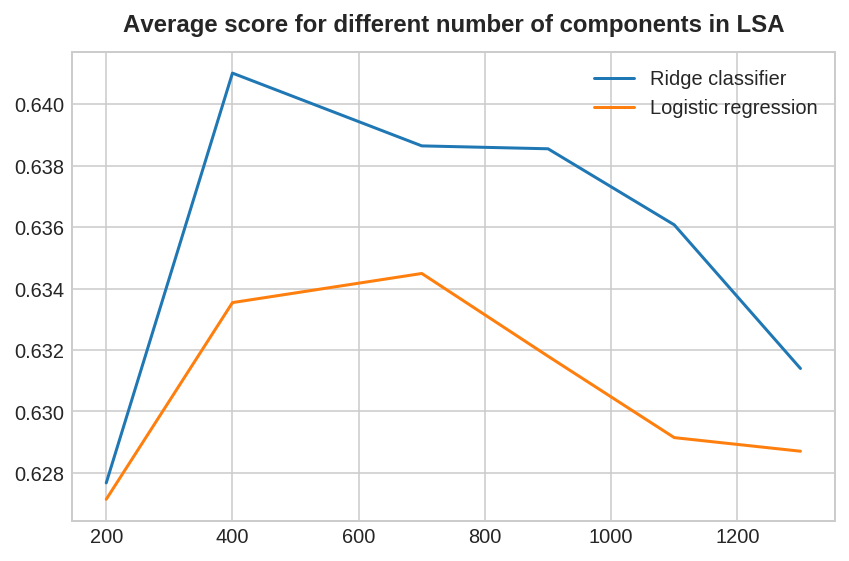

In [38]:
# Best number of components
plt.plot(number_list, ridge_classifier_f1, label = 'Ridge classifier')
plt.plot(number_list, logistic_regression_f1, label = 'Logistic regression')
plt.legend()
plt.title("Average score for different number of components in LSA")
plt.show()

In [39]:
max_f1 = np.argsort(-np.array(ridge_classifier_f1))[0]
print(f"Maximum F1 score: {number_list[max_f1]}: {ridge_classifier_f1[max_f1]}")

Maximum F1 score: 400: 0.6410178192488688


In [40]:
SVD_model = decomposition.TruncatedSVD(n_components=number_list[max_f1])
train_z = SVD_model.fit_transform(train_vectors_idf)

clf = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter=1000)

clf.fit(train_vectors, train_df["target"])
predict = clf.predict(train_vectors)
print(f'\nF1 score (train data) using all the data {metrics.f1_score(train_df["target"] ,predict)}')


F1 score (train data) using all the data 0.934875614007289


## 3.2 Using the new feature

Now, let's try our best model (LSA with 900 components with a ridge classifier) with the new feature to see if it improves our performance.

In [41]:
train_vectors_kw = count_vectorizer.fit_transform(train_df['text_kw_clean'])
test_vectors_kw = count_vectorizer.transform(test_df['text_kw_clean'])


#Count vectorizer method
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(lowercase=True)
train_vectors_idf_kw = tfidf_vectorizer.fit_transform(train_df["text_kw_clean"])
test_vectors_idf_kw = tfidf_vectorizer.transform(test_df["text_kw_clean"])

In [42]:
SVD_model_aux = decomposition.TruncatedSVD(n_components=900)
train_z_aux = SVD_model_aux.fit_transform(train_vectors_idf_kw)

clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, train_z_aux, train_df["target"], cv=3, scoring="f1")
print(f"Average score: {scores.mean()}\nList of scores: {scores}")

Average score: 0.6099836480371347
List of scores: [0.61852433 0.57075024 0.64067637]


In [43]:
clf.fit(train_z_aux, train_df["target"])
predict = clf.predict(train_z_aux)
print(f'\nF1 score (train data) using all the data {metrics.f1_score(train_df["target"] ,predict)}')


F1 score (train data) using all the data 0.8059897975974988


## 3.3 Summary of Baseline Models

Almost all baseline models yielded similar scores using 3-fold cross-validation. However, the best result was achieved with the LSA model (utilizing 900 components) combined with keyword features alongside the text. Notably, this model had the lowest F1 score on the full test sample, indicating some degree of overfitting in the other models.

We will use this LSA model as the baseline for submitting the test sample and comparing its performance against more advanced techniques.

## 3.4 Model evalutation on test data

In [44]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")


test_z_aux = SVD_model_aux.transform(test_vectors_kw)

sample_submission["target"] = clf.predict(test_z_aux)
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [45]:
sample_submission.to_csv("submission_baseline.csv", index=False)

## 3.5 Results

We achieved a F1 score of 0.73980 with this model

# 4. Advanced Modeling with BERT

In [46]:
import transformers

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

In [47]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [48]:
token_lens = []
for txt in train_df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [49]:
print(max_len)

55


In [50]:
#Lets take a look on the examples with more tokens
train_df['token_lens'] = token_lens
train_df = train_df.sort_values(by='token_lens', ascending=False)
train_df.head()

,id,keyword,location,text,target,text_clean,len_keyword,len_text,keyword_clean,text_kw_clean,token_lens
1924,2767,curfew,"Adelaide, Australia",INFO S. WND: 030/6. CLD: SCT014 BKN032. EXP IN...,0,info s wnd 0306 cld sct014 bkn032 exp inst apc...,1,27,curfew,info s wnd 0306 cld sct014 bkn032 exp inst apc...,55
1941,2792,curfew,"Adelaide, Australia",INFO U. CLD: SCT012 BKN025. EXP INST APCH. RWY...,0,info u cld sct012 bkn025 exp inst apch rwy 05 ...,1,27,curfew,info u cld sct012 bkn025 exp inst apch rwy 05 ...,55
1939,2787,curfew,"Adelaide, Australia",INFO R. CURFEW IN OPER UNTIL 2030 Z. TAXIWAYS ...,0,info r curfew in oper until 2030 z taxiway fox...,1,27,curfew,info r curfew in oper until 2030 z taxiway fox...,50
633,915,bioterrorism,NaN,@HowardU If 90BLKs&amp;8WHTs colluded 2 take W...,1,if 90blksamp8whts collude 2 take wht f auth ho...,1,20,bioterrorism,if 90blksamp8whts collude 2 take wht f auth ho...,45
614,885,bioterrorism,NaN,@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...,1,if 90blksamp8whts collude 2 take wht f auth ho...,1,20,bioterrorism,if 90blksamp8whts collude 2 take wht f auth ho...,45


In [51]:
X_train = train_df['text_kw_clean'].values
y_train = train_df['target'].values

In [52]:
MAX_LEN=70

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True,
            truncation = True
        )
        #For some reason padding = max_length is not working, so we will add the padding manually
        len_tokens = len(encoded['input_ids']) 
        
        padding_list = []
        if len_tokens < max_len:
            padding_list = [0]*(max_len - len_tokens)
        
        input_ids.append(encoded['input_ids'] + padding_list)
        attention_masks.append(encoded['attention_mask'] + padding_list)
    return np.array(input_ids),np.array(attention_masks)

In [53]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)

In [54]:
train_input_ids.shape

(7613, 70)

In [55]:
train_attention_masks[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

## 4.1 Model with BERT

In [56]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [57]:
def create_model(bert_model, max_len=100):

    ##params###
    # define optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)

    # define loss
    loss = tf.keras.losses.BinaryCrossentropy()
    
    # evaluate model accuracy
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # define model entry
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    # separate embeddings
    embeddings = bert_model([input_ids,attention_masks])[1]

    # create a new layer for class prediction
    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)

    # compiles the model
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=[accuracy])

    return model

In [58]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 70, 768), (N 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            769         tf_bert_model[0][1]          

In [59]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
len(train_attention_masks[4])

70

In [61]:
#Fitting the model
history_bert = model.fit(
    [train_input_ids,train_attention_masks],
    y_train,
    epochs=1,
    batch_size=50
                  )

Train on 7613 samples
7613/7613 [==============================] - 3041s 399ms/sample - loss: 0.4701 - categorical_accuracy: 1.0000


In [62]:
#result_bert = model.predict([train_input_ids,train_attention_masks])
#y_pred_bert =  np.zeros_like(result_bert)
#y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

## 4.2 Model evaluation

In [63]:
X_test = test_df['text_kw_clean'].values

test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [64]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [65]:
y_pred_bert =  np.where(result_bert>=0.5, int(1), int(0))

In [66]:
result_bert[50:53]

array([[0.11112061],
       [0.10372922],
       [0.6130167 ]], dtype=float32)

In [67]:
y_pred_bert[50:53]

array([[0],
       [0],
       [1]])

In [68]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")


sample_submission["target"] = y_pred_bert
sample_submission.head()
sample_submission.to_csv("submission_bert.csv", index=False)

## 4.3 Model evalutation on test data¶

Using this model, we achieved a **F1 score of 0.82653**, which is a significant improvement against the baseline model

# 5. Conclusion

In this analysis, we tested various models to determine whether tweets were related to disasters. The most effective model was the BERT-based neural network, which achieved an F1 score of 0.83.

Due to time constraints, hyperparameter optimization was not performed on the model, which could potentially enhance its performance. Additionally, exploring other transformers such as RoBERTa could provide further insights.

The next step would be to deploy the model to process incoming tweets and return prediction outputs.